## Load-in dependencies:

In [1]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [2]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies)=#

In [3]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile

In [4]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [62]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

## Read in BXD data:

In [6]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [7]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [9]:
using StatsBase

In [10]:
n_seeds = 4;

In [11]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false)

4-element Vector{Int64}:
  7
 87
 71
 91

## Rotate the data:

In [22]:
(y0, X0, lambda0) = transform1(pheno_y, geno, kinship);

## Using map() (sequential processing)

In [77]:
map_results = map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
map_LODs = reduce(vcat, map_results);

In [78]:
seeds_list

4-element Vector{Int64}:
  7
 87
 71
 91

In [79]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5;
BenchmarkTools.DEFAULT_PARAMETERS.evals = 1;

In [80]:
@benchmark map(x -> scan_perms2(pheno_y, geno, kinship; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.038 s …  4.048 s  ┊ GC (min … max): 28.26% … 28.23%
 Time  (median):     4.043 s             ┊ GC (median):    28.25%
 Time  (mean ± σ):   4.043 s ± 6.738 ms  ┊ GC (mean ± σ):  28.25% ±  0.02%

  █                                                      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  440 s         Histogram: frequency by time         450 s <

 Memory estimate: 5.41 GiB, allocs estimate: 464582.

In [81]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.413 s …   4.483 s  ┊ GC (min … max): 27.92% … 28.89%
 Time  (median):     4.448 s              ┊ GC (median):    28.41%
 Time  (mean ± σ):   4.448 s ± 49.651 ms  ┊ GC (mean ± σ):  28.41% ±  0.68%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.41 s         Histogram: frequency by time        4.48 s <

 Memory estimate: 5.38 GiB, allocs estimate: 296821.

In [82]:
@benchmark map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.951 s …   3.994 s  ┊ GC (min … max): 27.98% … 28.28%
 Time  (median):     3.972 s              ┊ GC (median):    28.13%
 Time  (mean ± σ):   3.972 s ± 30.255 ms  ┊ GC (mean ± σ):  28.13% ±  0.21%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.95 s         Histogram: frequency by time        3.99 s <

 Memory estimate: 5.37 GiB, allocs estimate: 296798.

## Using distributed pmap() (parallel processing)

In [83]:
using Distributed

In [84]:
# addprocs(2);

In [65]:
# procs()

In [66]:
# rmprocs([2, 3])

In [67]:
procs()

3-element Vector{Int64}:
 1
 4
 5

In [68]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [69]:
pmap_results = pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
pmap_LODs = reduce(vcat, pmap_results);

In [70]:
@benchmark pmap(x -> scan_perms2($pheno_y, $geno, $kinship; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.853 s …   2.022 s  ┊ GC (min … max): 0.00% … 0.08%
 Time  (median):     1.873 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.916 s ± 92.102 ms  ┊ GC (mean ± σ):  0.03% ± 0.05%

  █     █                                                 █  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.85 s         Histogram: frequency by time         220 s <

 Memory estimate: 22.56 MiB, allocs estimate: 1056.

In [71]:
@benchmark begin
    transform1(pheno_y, geno, kinship)
    pmap(x -> scan_distributed($y0, $X0, $lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.842 s …   2.017 s  ┊ GC (min … max): 0.00% … 0.15%
 Time  (median):     1.859 s              ┊ GC (median):    0.17%
 Time  (mean ± σ):   1.906 s ± 96.766 ms  ┊ GC (mean ± σ):  0.12% ± 0.10%

  █    █                                                  █  
  █▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.84 s         Histogram: frequency by time         220 s <

 Memory estimate: 31.38 MiB, allocs estimate: 1206.

In [72]:
@benchmark pmap(x -> scan_distributed($y0, $X0, $lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.997 s …   2.023 s  ┊ GC (min … max): 0.00% … 0.09%
 Time  (median):     2.015 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.012 s ± 13.206 ms  ┊ GC (mean ± σ):  0.03% ± 0.05%

  █                                      █                █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2 s            Histogram: frequency by time         220 s <

 Memory estimate: 22.38 MiB, allocs estimate: 1317.

## Check results from the latest updated version:

In [85]:
map_LODs

400×7321 Matrix{Float64}:
 0.167482     0.167482     0.167482     …  0.00532562   0.167482
 0.111096     0.111096     0.111096        0.00569372   0.111096
 0.317271     0.317271     0.317271        0.328268     0.317264
 0.0532897    0.0532897    0.0532897       0.0344003    0.0532889
 0.0417396    0.0417396    0.0417396       0.00644623   0.0417392
 0.0352567    0.0352567    0.0352567    …  0.00676418   0.0352564
 0.0134889    0.0134889    0.0134889       0.00676414   0.0134887
 0.0140968    0.0140968    0.0140968       0.00312822   0.014097
 4.49464e-8   4.49464e-8   4.49464e-8      0.0439358    4.40826e-8
 0.21444      0.21444      0.21444         0.371923     0.214434
 0.000454836  0.000454836  0.000454836  …  0.317235     0.000454603
 0.0120091    0.0120091    0.0120091       0.00487024   0.012009
 0.000301431  0.000301431  0.000301431     0.0154592    0.000301389
 ⋮                                      ⋱               ⋮
 0.00569568   0.00569568   0.00569568      0.00569514   0.0

In [86]:
pmap_LODs

400×7321 Matrix{Float64}:
 0.167482     0.167482     0.167482     …  0.00532562  0.167482
 0.111096     0.111096     0.111096        0.00569372  0.111096
 0.317271     0.317271     0.317271        0.328268    0.317264
 0.0532897    0.0532897    0.0532897       0.0344003   0.0532889
 0.0417396    0.0417396    0.0417396       0.00644623  0.0417392
 0.0352567    0.0352567    0.0352567    …  0.00676418  0.0352564
 0.0134889    0.0134889    0.0134889       0.00676414  0.0134887
 0.0140968    0.0140968    0.0140968       0.00312822  0.014097
 4.49464e-8   4.49464e-8   4.49464e-8      0.0439358   4.40826e-8
 0.21444      0.21444      0.21444         0.371923    0.214434
 0.000454836  0.000454836  0.000454836  …  0.317235    0.000454603
 0.0120091    0.0120091    0.0120091       0.00487024  0.012009
 0.000301431  0.000301431  0.000301431     0.0154592   0.000301389
 ⋮                                      ⋱              ⋮
 0.0056957    0.0056957    0.0056957       0.0532881   0.00569507
 0.0439

In [97]:
sum(map_LODs[:, 7321])

128.70524964851458

In [96]:
sum(pmap_LODs[:, 7321])

182.88451631463894

In [98]:
normal_LODs = scan_perms(pheno_y, geno, kinship; nperms = 400, original = false)

400×7321 Matrix{Float64}:
 1.71913      1.71913      1.71913      …  0.331233    0.452205    0.452205
 0.225974     0.225974     0.225974        0.236999    0.201861    0.201861
 0.0167808    0.0167808    0.0167808       0.0172833   0.00762492  0.00762492
 0.0800067    0.0800067    0.0800067       2.48762e-5  0.00972036  0.00972036
 0.000354535  0.000354535  0.000354535     0.412733    0.383925    0.383925
 0.58573      0.58573      0.58573      …  0.238672    0.202066    0.202066
 0.519134     0.519134     0.519134        0.0731073   0.0839292   0.0839292
 3.18899e-5   3.18899e-5   3.18899e-5      0.0556109   0.144341    0.144341
 1.03257      1.03257      1.03257         0.15682     0.183653    0.183653
 0.0559665    0.0559665    0.0559665       0.0913656   0.0507086   0.0507086
 0.0760841    0.0760841    0.0760841    …  0.0701066   0.0705379   0.0705379
 0.0890595    0.0890595    0.0890595       0.0363576   0.167509    0.167509
 0.219432     0.219432     0.219432        0.4006      

In [106]:
function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)

In [109]:
max_lods_normal = getMaxLod(normal_LODs);

In [112]:
max_lods_map = getMaxLod(map_LODs);

In [113]:
pmax_lods_pmap = getMaxLod(pmap_LODs);

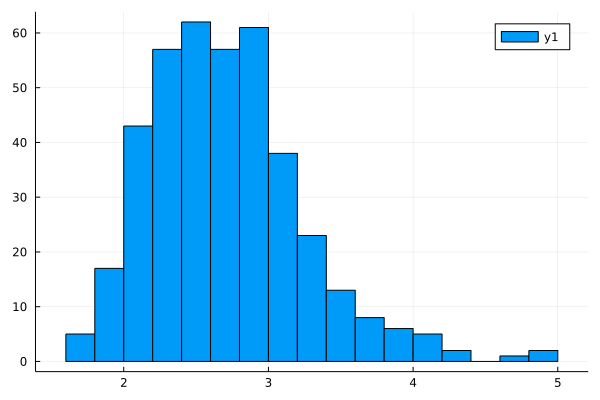

In [116]:
histogram(max_lods_normal)

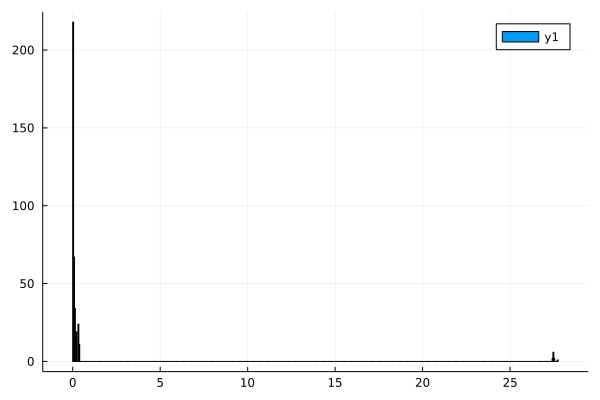

In [117]:
histogram(max_lods_map)

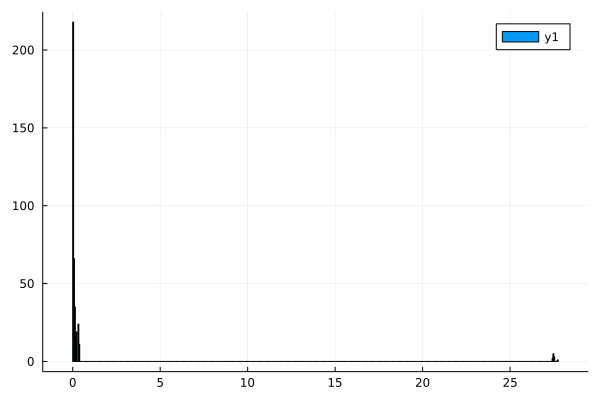

In [118]:
histogram(max_lods_pmap)

In [30]:
r1 = map(x -> permuteHelper(pheno_y, geno, kinship; nperms = 2, rndseed = x, original = false), seeds_list);

In [31]:
r2 = pmap(x -> permuteHelper(pheno_y, geno, kinship; nperms = 2, rndseed = x, original = false), seeds_list);

In [32]:
sum(r1[3][5].== r2[3][5])

79

In [33]:
spec_kinship = eigen(kinship);

In [34]:
count(i -> (i > 0.0001), r1[4][4].-r2[4][4]) # compare y0 - after rotation

0

In [35]:
r1[4][1][1:6]

6-element Vector{Float64}:
  0.310170284792575
 -0.3136148522780779
  0.5869441837134927
  0.015481219542282992
  0.8128646153914731
 -1.1383735183126595

In [36]:
r2[4][1][1:6]

6-element Vector{Float64}:
  0.310170284792575
 -0.3136148522780779
  0.5869441837134927
  0.015481219542282992
  0.8128646153914731
 -1.1383735183126595

In [37]:
seeds_list

4-element Vector{Int64}:
 65
 59
 17
  1

### If we pass the same processed data (r0perm, X00) and compare computing LODs using map and pmap...

In [38]:
test_lods1 = map(x -> sim_for_test(r1[x][1], r1[x][2]), 1:4);

In [39]:
test_lods2 = pmap(x -> sim_for_test(r1[x][1], r1[x][2]), 1:4);

In [40]:
# order = StatsBase.sample(1:4, 4, replace = false)
order = 1:4

1:4

In [41]:
@btime map(x -> sim_for_test(r1[x][1], r1[x][2]), order);

  34.777 ms (205032 allocations: 123.78 MiB)


In [42]:
@btime pmap(x -> sim_for_test(r1[x][1], r1[x][2]), order);

  33.393 ms (205084 allocations: 123.78 MiB)


In [43]:
test_lods1= map(x -> sim_for_test(r1[x][1], r1[x][2]), order);

In [44]:
test_lods1b= map(x -> sim_for_test(r2[x][1], r2[x][2]), order);

In [45]:
test_lods2 = pmap(x -> sim_for_test(r1[x][1], r1[x][2]), order);

In [46]:
test_lods2b = pmap(x -> sim_for_test(r2[x][1], r2[x][2]), order);

In [47]:
reduce(vcat, test_lods1)

8×7321 Matrix{Float64}:
 0.297292   0.297292   0.297292   …  0.602256    0.431872    0.431872
 0.01159    0.01159    0.01159       0.0149438   0.108856    0.108856
 0.0429846  0.0429846  0.0429846     0.0355052   0.00360723  0.00360723
 0.0338363  0.0338363  0.0338363     0.00622138  0.0769632   0.0769632
 0.380555   0.380555   0.380555      0.00160756  0.0137792   0.0137792
 0.34174    0.34174    0.34174    …  0.206209    0.18714     0.18714
 0.182887   0.182887   0.182887      0.179358    0.0201669   0.0201669
 0.310372   0.310372   0.310372      0.010389    0.0833686   0.0833686

In [48]:
reduce(vcat, test_lods1b)

8×7321 Matrix{Float64}:
 0.297292   0.297292   0.297292   …  0.602256    0.431872    0.431872
 0.01159    0.01159    0.01159       0.0149438   0.108856    0.108856
 0.0429846  0.0429846  0.0429846     0.0355052   0.00360723  0.00360723
 0.0338363  0.0338363  0.0338363     0.00622138  0.0769632   0.0769632
 0.380555   0.380555   0.380555      0.00160756  0.0137792   0.0137792
 0.34174    0.34174    0.34174    …  0.206209    0.18714     0.18714
 0.182887   0.182887   0.182887      0.179358    0.0201669   0.0201669
 0.310372   0.310372   0.310372      0.010389    0.0833686   0.0833686

In [49]:
reduce(vcat, test_lods2)

8×7321 Matrix{Float64}:
 0.297292   0.297292   0.297292   …  0.602256    0.431872    0.431872
 0.01159    0.01159    0.01159       0.0149438   0.108856    0.108856
 0.0429846  0.0429846  0.0429846     0.0355052   0.00360723  0.00360723
 0.0338363  0.0338363  0.0338363     0.00622138  0.0769632   0.0769632
 0.380555   0.380555   0.380555      0.00160756  0.0137792   0.0137792
 0.34174    0.34174    0.34174    …  0.206209    0.18714     0.18714
 0.182887   0.182887   0.182887      0.179358    0.0201669   0.0201669
 0.310372   0.310372   0.310372      0.010389    0.0833686   0.0833686

In [50]:
reduce(vcat, test_lods2b)

8×7321 Matrix{Float64}:
 0.297292   0.297292   0.297292   …  0.602256    0.431872    0.431872
 0.01159    0.01159    0.01159       0.0149438   0.108856    0.108856
 0.0429846  0.0429846  0.0429846     0.0355052   0.00360723  0.00360723
 0.0338363  0.0338363  0.0338363     0.00622138  0.0769632   0.0769632
 0.380555   0.380555   0.380555      0.00160756  0.0137792   0.0137792
 0.34174    0.34174    0.34174    …  0.206209    0.18714     0.18714
 0.182887   0.182887   0.182887      0.179358    0.0201669   0.0201669
 0.310372   0.310372   0.310372      0.010389    0.0833686   0.0833686

which turned out to be the same. This suggests that the issue might be in the process of transforming the original data.

In [51]:
pmap_results = pmap(x -> scan_perms2(pheno_y, geno, kinship; nperms = 2, rndseed = x, original = false), seeds_list);

In [52]:
map_results = map(x -> scan_perms2(pheno_y, geno, kinship; nperms = 2, rndseed = x, original = false), seeds_list);

In [53]:
size(pmap_results)

(4,)

In [54]:
total_LODs_pmap = reduce(vcat, pmap_results);

In [55]:
total_LODs_map = reduce(vcat, map_results);

In [56]:
total_LODs_map

8×7321 Matrix{Float64}:
 0.297292   0.297292   0.297292   …  0.602256    0.431872    0.431872
 0.01159    0.01159    0.01159       0.0149438   0.108856    0.108856
 0.0429846  0.0429846  0.0429846     0.0355052   0.00360723  0.00360723
 0.0338363  0.0338363  0.0338363     0.00622138  0.0769632   0.0769632
 0.380555   0.380555   0.380555      0.00160756  0.0137792   0.0137792
 0.34174    0.34174    0.34174    …  0.206209    0.18714     0.18714
 0.182887   0.182887   0.182887      0.179358    0.0201669   0.0201669
 0.310372   0.310372   0.310372      0.010389    0.0833686   0.0833686

In [57]:
total_LODs_pmap

8×7321 Matrix{Float64}:
 0.297292   0.297292   0.297292   …  0.602256    0.431872    0.431872
 0.01159    0.01159    0.01159       0.0149438   0.108856    0.108856
 0.0429846  0.0429846  0.0429846     0.0355052   0.00360723  0.00360723
 0.0338363  0.0338363  0.0338363     0.00622138  0.0769632   0.0769632
 0.380555   0.380555   0.380555      0.00160756  0.0137792   0.0137792
 0.34174    0.34174    0.34174    …  0.206209    0.18714     0.18714
 0.182887   0.182887   0.182887      0.179358    0.0201669   0.0201669
 0.310372   0.310372   0.310372      0.010389    0.0833686   0.0833686

In [58]:
eigvecs(kinship)' * pheno_y

79×1 Matrix{Float64}:
  -0.15454509960204277
  -0.5354364121131638
   0.5330955029115003
  -0.3695747124981319
   0.5933344358411334
   0.15839173290108022
   0.18508420366575784
  -0.02984192925129392
  -0.34006190946237824
  -0.3480070872243979
   0.0003077494892007593
   0.10160361271707097
  -0.026710388338434754
   ⋮
  -0.3488386107728494
  -0.29415005692425833
   0.03212949434779233
   1.4861115587495042
   0.7231901992036516
   0.9275943478743782
  -2.0472452599132023
   2.14352097827763
   0.13484048006067084
  -0.6437417316481032
  -3.5023797684093645
 -99.67082460647165

In [59]:
r2[1][4]

79×1 Matrix{Float64}:
  -0.15454509960204277
  -0.5354364121131638
   0.5330955029115003
  -0.3695747124981319
   0.5933344358411334
   0.15839173290108022
   0.18508420366575784
  -0.02984192925129392
  -0.34006190946237824
  -0.3480070872243979
   0.0003077494892007593
   0.10160361271707097
  -0.026710388338434754
   ⋮
  -0.3488386107728494
  -0.29415005692425833
   0.03212949434779233
   1.4861115587495042
   0.7231901992036516
   0.9275943478743782
  -2.0472452599132023
   2.14352097827763
   0.13484048006067084
  -0.6437417316481032
  -3.5023797684093645
 -99.67082460647165